# Oort parameters & SF

In [1]:
import numpy as np
import os
from IPython.display import Image
from scipy import stats
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import functions

importing Jupyter notebook from functions.ipynb
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
Distance = 9.3 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [4]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
Sigma_SFR = np.load('./data/Sigma_SFR.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
r_HI_old = np.load('./data/r_HI_old.npy')
vel_HI_old = np.load('./data/vel_HI_old.npy')
velocity_HI = np.load('./data/velocity_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc_corr.npy')
sig_R_min_err = np.load('./data/sig_R_min_err.npy')
sig_R_max_err = np.load('./data/sig_R_max_err.npy')
sigma_s_err = np.load('./data/sigma_s_err.npy')
H_alpha = np.load('./data/H_alpha.npy')
Z = np.load('./data/Z.npy')

In [5]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [6]:
G = 4.32
Sigma_crit = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
 
        A = 0.5 * (velocity_approx(dist_kpc[i][j]) / dist_kpc[i][j] - velocity_approx.deriv()(dist_kpc[i][j]))  
        sigma_g = sigma_HI[i][j]/1000.
  
        Sigma_crit[i][j] = 0.4 * A * sigma_g / np.pi / G
    
Sigma_gas = 1.36 * (Sigma_HI + Sigma_H2)    

## The effect of differential rotation (using the two Oort parameters A and B )

[статья](https://arxiv.org/pdf/2003.02848.pdf)

$$\log{\Sigma_{SFR}} \propto \log{ 2 A^2 + 5 B^2}$$

$$A = | -0.5 \left( \dfrac{v(r_{gal})}{r_{gal}} - \dfrac{dv(r_{gal})}{dr_{gal}} \right) |$$
$$B = | -0.5 \left( \dfrac{v(r_{gal})}{r_{gal}} + \dfrac{dv(r_{gal})}{dr_{gal}} \right) |$$

In [7]:
def azimuthal_average(Q, step=None, vmax=None, maxval=None, vmin=0.1):
    az_av = []
    az_dev = []
    anulli = []
    for dbin in np.arange(vmin,vmax,step):
        mask = (dist_kpc >= dbin) & (dist_kpc <= dbin + step)
        anulli = Q[mask]
        mask = (anulli < maxval) & (anulli > 0.) 
        anulli = anulli[mask]
        az_av.append(anulli.sum()/mask.sum())
        az_dev.append(np.std(anulli))
    return az_av, az_dev

In [8]:
R = np.array(np.linspace(0.1,9.1,90))
A = [0.5 * (velocity_approx(dist) / dist - velocity_approx.deriv()(dist)) for dist in R]
B = [-0.5 * (velocity_approx(dist) / dist + velocity_approx.deriv()(dist)) for dist in R]
Sigma_SFR_az = azimuthal_average(Sigma_SFR, step=0.1, vmax=9.1, maxval = 5.)[0]


diff_rot = [2 * A[i]**2 + 5 * B[i]**2 for i in range(len(R))] 

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/lera/.local/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lera/.local/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lera/.local/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Galactocentric Radius [kpc]')

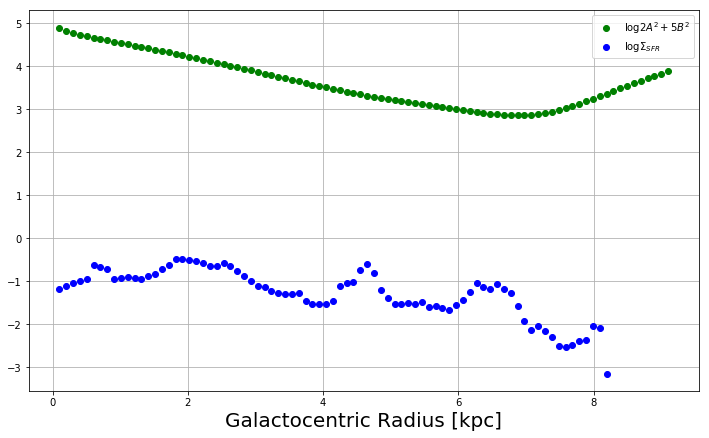

In [9]:
fig = plt.figure(figsize=[12, 7])
plt.plot(R, np.log10(diff_rot), 'o', lw=1, color='g',label=r'$\log{ 2 A^2 + 5 B^2}$')
plt.plot(R, np.log10(Sigma_SFR_az), 'o', lw=1, color='b',label=r'$\log{\Sigma_{SFR}}$')
plt.grid()
plt.legend()
plt.xlabel(r'Galactocentric Radius [kpc]', fontsize = 20)


In [10]:
from scipy import stats


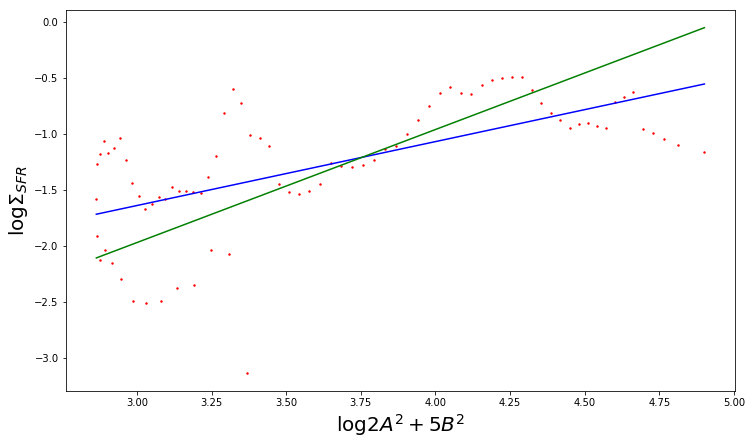

0.57 -3.35


In [11]:
x=np.log10(diff_rot[0:-9])
y=np.log10(Sigma_SFR_az[0:-9])
fig = plt.figure(figsize=[12, 7])
plt.scatter(x,y, 2., color='r')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
gradient1=1.01  # взяла из статьи
intercept1 = -5. # подобрала
x1=np.array(np.linspace(mn,mx,100))
y1=x1*gradient+intercept
x2=np.array(np.linspace(mn,mx,100))
y2=x2*gradient1+intercept1
plt.plot(x1,y1,'-',color='b')
plt.plot(x2,y2,'-',color='g')

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=20)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=20)
plt.show()
print('{:2.2f}'.format(gradient),'{:2.2f}'.format(intercept))

$$\log{\Sigma_{SFR}} = -3.35 + 0.57\times \log{( 2 A^2 + 5 B^2)}$$



In [12]:
Diff_rot = np.zeros(dist_kpc.shape)
A_2d = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
 
        A_2d[i][j] = 0.5 * (velocity_approx(dist_kpc[i][j]) / dist_kpc[i][j] - velocity_approx.deriv()(dist_kpc[i][j]))
        B = -0.5 * (velocity_approx(dist_kpc[i][j]) / dist_kpc[i][j] + velocity_approx.deriv()(dist_kpc[i][j])) 
         
        Diff_rot[i][j] =2 * A_2d[i][j]**2 + 5 * B**2

In [13]:
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


0.7172631192997403 -4.123301983090974


Text(0.5, 0, '$\\log{2 A^2 + 5 B^2}$')

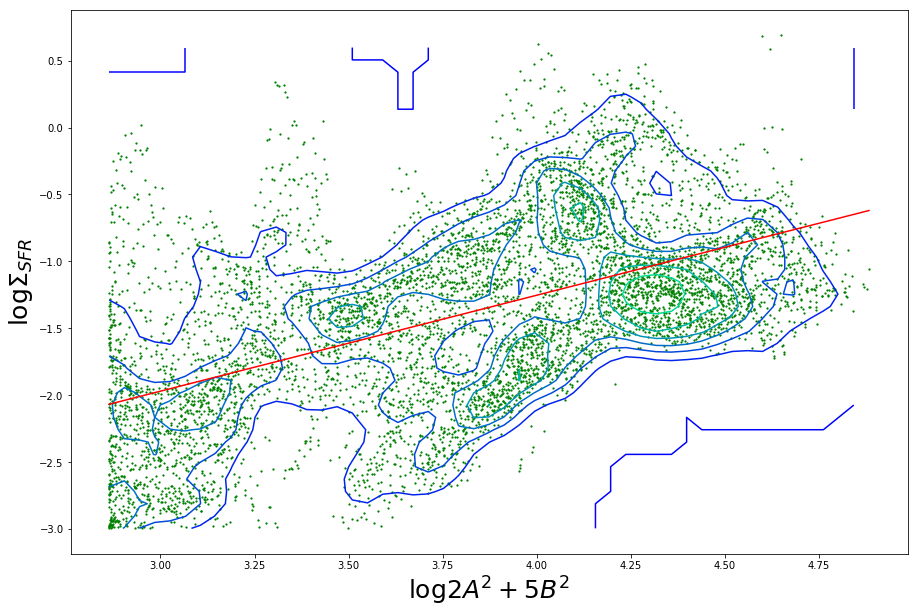

In [110]:
fig = plt.figure(figsize=[15,10])
indxs = (Sigma_SFR != nan) & (Diff_rot != 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)
y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(Diff_rot[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)

#indxs1 =  (x <= 2.9) & (-3 <= y < 0)
#y1,x1 = np.ravel(y[indxs1]), np.ravel(x[indxs1])
                                                                                                         
#x1=np.nan_to_num(x1)
#y1=np.nan_to_num(y1)

#indxs2 = (Sigma_SFR != nan) & (Diff_rot != 0) & (dist_kpc > 0.1) & (3.2 <= np.log10(Diff_rot) <= 3.4) & (-1 <= np.log10(Sigma_SFR) < 0.5)                  
#y2,x2 = np.ravel(np.log10(Sigma_SFR)[indxs2]), np.log10(np.ravel(Diff_rot[indxs2]))

#x2=np.nan_to_num(x2)
#y2=np.nan_to_num(y2)

#indxs3 = (Sigma_SFR != nan) & (Diff_rot != 0) & (dist_kpc > 0.1) & (3.85 <= np.log10(Diff_rot) <= 4.5) & (-0.75 <= np.log10(Sigma_SFR) < 0.5)
#y3,x3 = np.ravel(np.log10(Sigma_SFR)[indxs3]), np.log10(np.ravel(Diff_rot[indxs3]))

#x3=np.nan_to_num(x3)
#y3=np.nan_to_num(y3)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1.5, color='g')
#plt.scatter(x1,y1, 1., color='r')
#plt.scatter(x2,y2, 1., color='purple')
#plt.scatter(x3,y3, 1., color='b')
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=25)
#plt.ylim(0.,2.5)
#plt.xlim(-3,0.5)



$$\log{\Sigma_{SFR}} = -4.12 + 0.72\times \log{( 2 A^2 + 5 B^2)}$$



Выделим некоторые области на графике и поймём, где они располагаются на карте:

In [20]:
fields = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        if(np.log10(Diff_rot[i][j]) <= 2.9) & (-3 <= np.log10(Sigma_SFR[i][j]) < 0):
            fields[i][j] = 1
        
        elif(3.2 <= np.log10(Diff_rot[i][j]) <= 3.4) & (-1 <= np.log10(Sigma_SFR[i][j]) < 0.5):
            fields[i][j] = 2
            
        elif(3.85 <= np.log10(Diff_rot[i][j]) <= 4.5) & (-0.75 <= np.log10(Sigma_SFR[i][j]) < 0.5):
            fields[i][j] = 3    

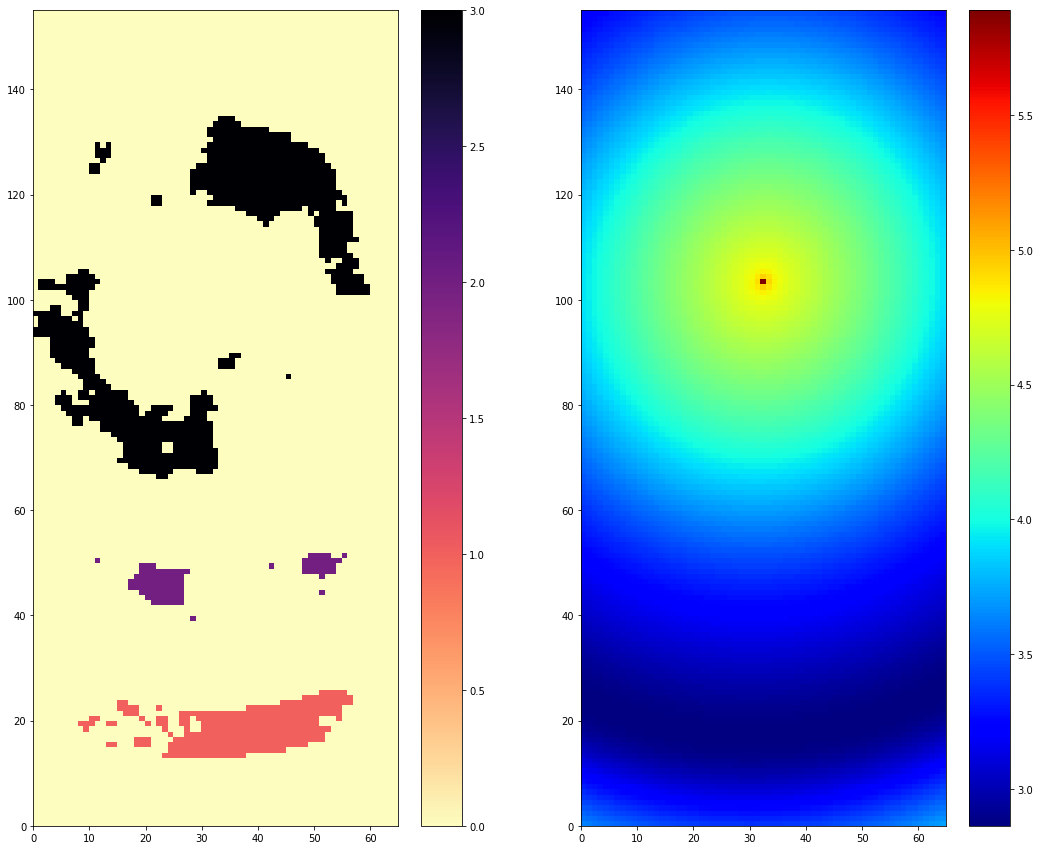

In [21]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[18,15])
plt.subplot(1,2,1)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, fields, cmap='magma_r')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

plt.subplot(1,2,2)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, np.log10(Diff_rot), cmap='jet')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

Выделим на картинке спирали области со спиралями.

/home/lera/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


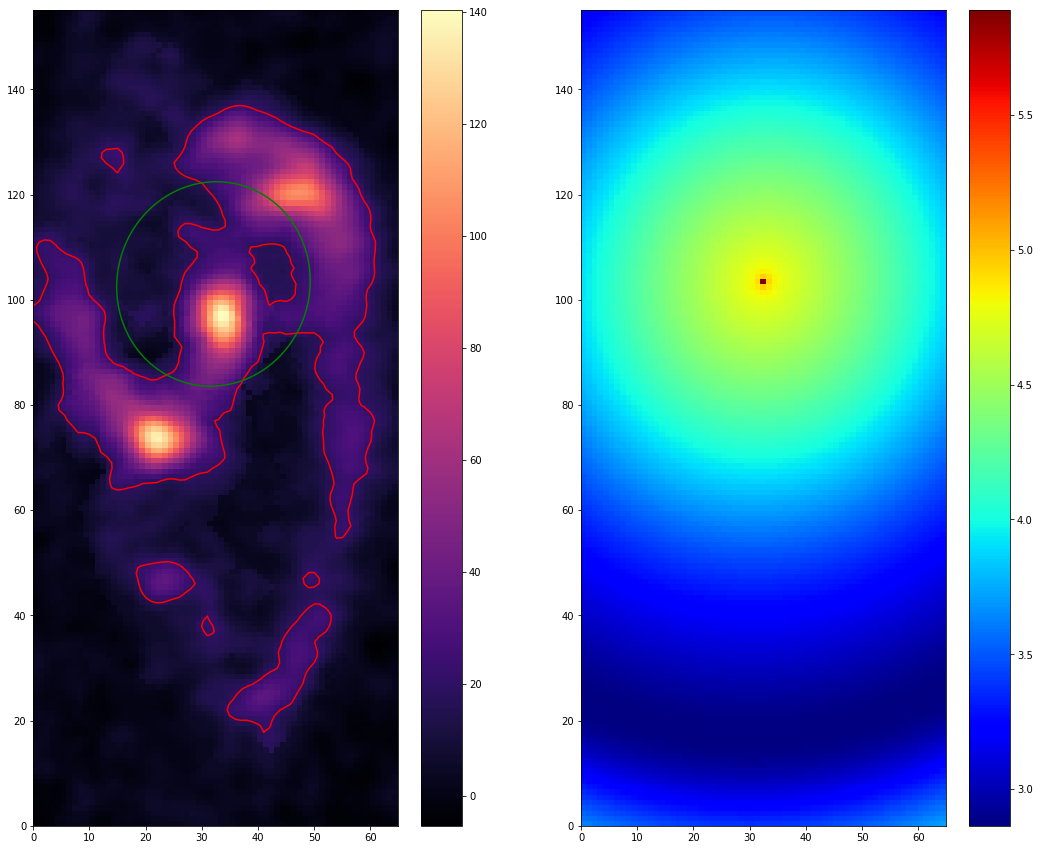

In [22]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[18,15])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_H2, levels=[20,], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,1.55], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y,Sigma_H2, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax = 4000)
plt.colorbar()

plt.subplot(1,2,2)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, np.log10(Diff_rot), cmap='jet')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


0.7172631192997403 -4.123301983090974


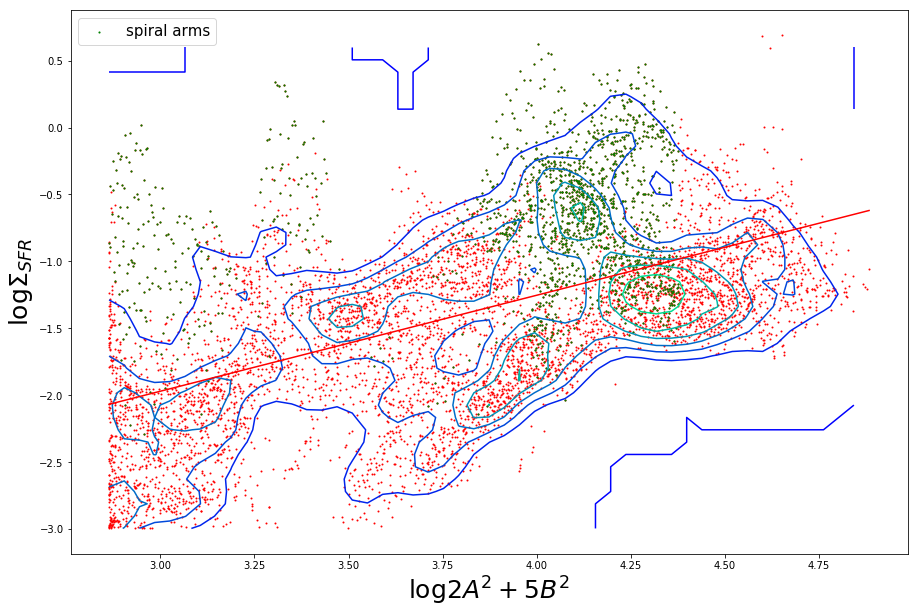

In [23]:
fig = plt.figure(figsize=[15,10])
indxs = (Sigma_SFR != nan) & (Diff_rot != 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(Diff_rot[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)

indxs1 = indxs & (1.55 < dist_kpc) & (Sigma_H2>20)

y_,x_ = np.ravel(np.log10(Sigma_SFR)[indxs1]), np.log10(np.ravel(Diff_rot[indxs1]))

x_=np.nan_to_num(x_)
y_=np.nan_to_num(y_)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.scatter(x_,y_, 1.2, color='g',label = 'spiral arms')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=25)
plt.legend(fontsize = 15)

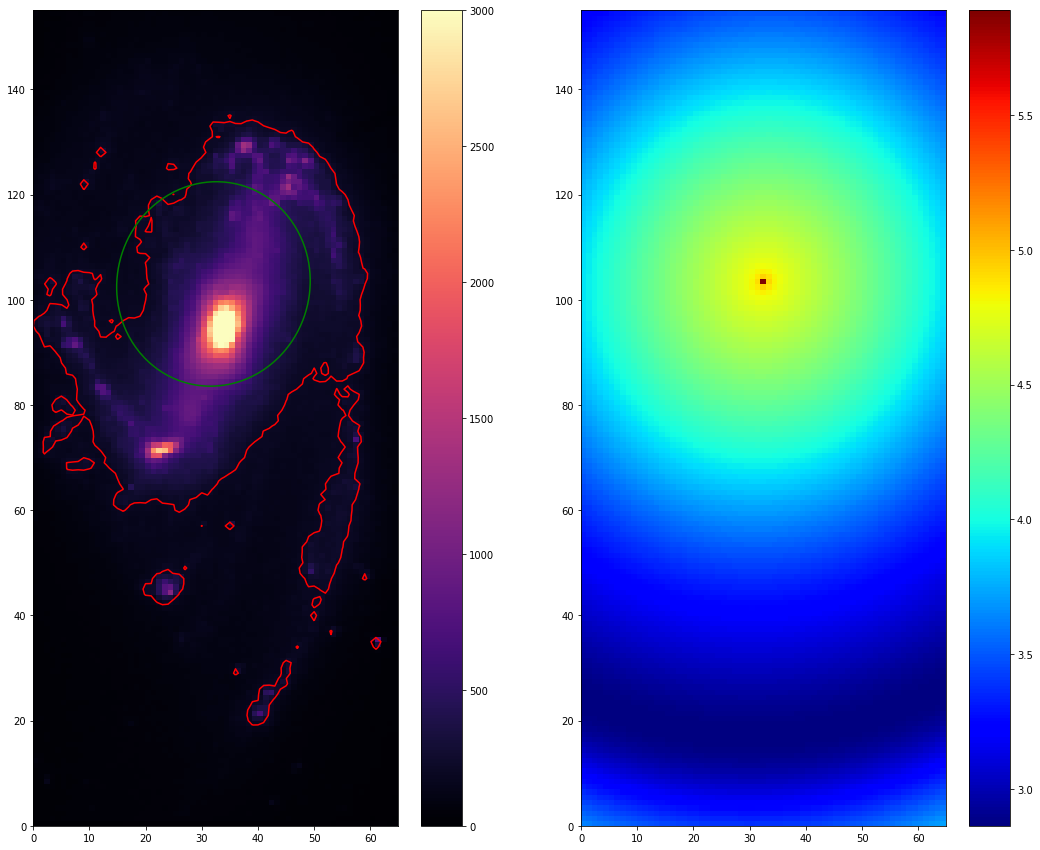

In [105]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[18,15])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_s, levels=[200,], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,1.55], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y,Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax = 3000)
plt.colorbar()

plt.subplot(1,2,2)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, np.log10(Diff_rot), cmap='jet')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


0.7172631192997403 -4.123301983090974


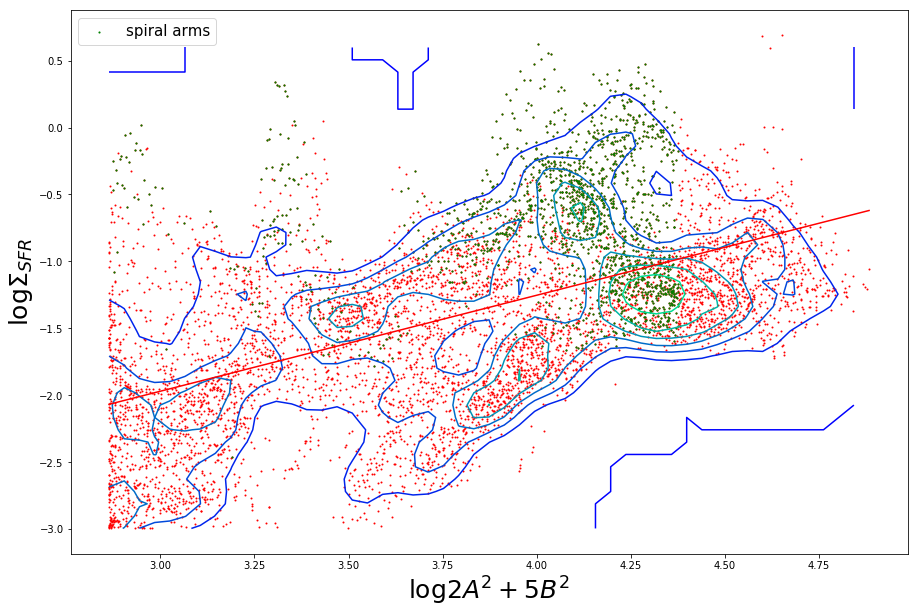

In [106]:
fig = plt.figure(figsize=[15,10])
indxs = (Sigma_SFR != nan) & (Diff_rot != 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(Diff_rot[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)

indxs1 = indxs & (1.55 < dist_kpc) & (Sigma_s>200)

y_,x_ = np.ravel(np.log10(Sigma_SFR)[indxs1]), np.log10(np.ravel(Diff_rot[indxs1]))

x_=np.nan_to_num(x_)
y_=np.nan_to_num(y_)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.scatter(x_,y_, 1.2, color='g',label = 'spiral arms')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=25)
plt.legend(fontsize = 15)

Разберёмся с вопросом про shear & $\Sigma_{SFR}$

In [35]:
print(A)

[18.480008381685735, 10.756947550469611, 8.877582892102097, 8.431127248500971, 8.543075954443275, 8.922837409389743, 9.44598923152661, 10.05027805133102, 10.701038478776404, 11.377383769880403, 12.06593647309532, 12.757696657671787, 13.446356811555049, 14.127339499516335, 14.797220243381432, 15.453366972569558, 16.093706810609316, 16.71657064749872, 17.320586823197715, 17.904606723802225, 18.467651647207887, 19.008874167278933, 19.527529581800835, 20.022954501751045, 20.49455058142953, 20.9417720047798, 21.364115753672284, 21.76111396238353, 22.132327854513385, 22.477342892968252, 22.795764868993686, 23.087216724768137, 23.351335953901504, 23.587772460819206, 23.796186787225505, 23.976248634247536, 24.12763562430365, 24.250032258523397, 24.343129034610154, 24.40662169706117, 24.440210597141107, 24.44360014431235, 24.416498334229455, 24.358616341114516, 24.269668164495606, 24.149370322034265, 23.99744158157551, 23.813602726699493, 23.597576350987573, 23.349086676981997, 23.0678593964489

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


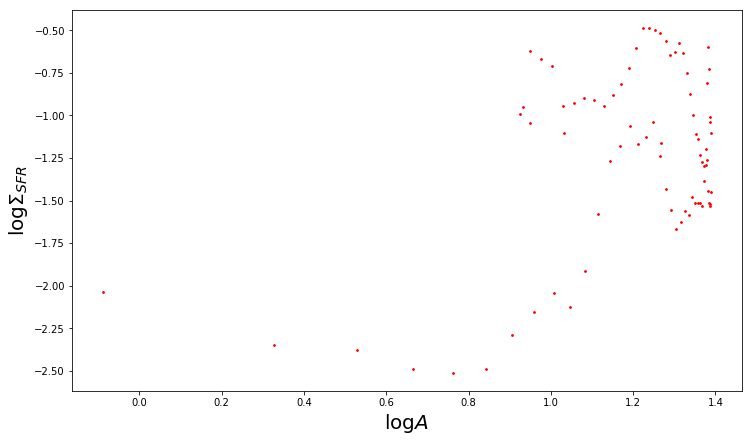

In [37]:
x=np.log10(A[0:-9])
y=np.log10(Sigma_SFR_az[0:-9])
fig = plt.figure(figsize=[12, 7])
plt.scatter(x,y, 3., color='r')

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=20)
plt.xlabel(r'$\log{A}$',fontsize=20)
plt.show()


/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


(-3, 0.8758178613286525)

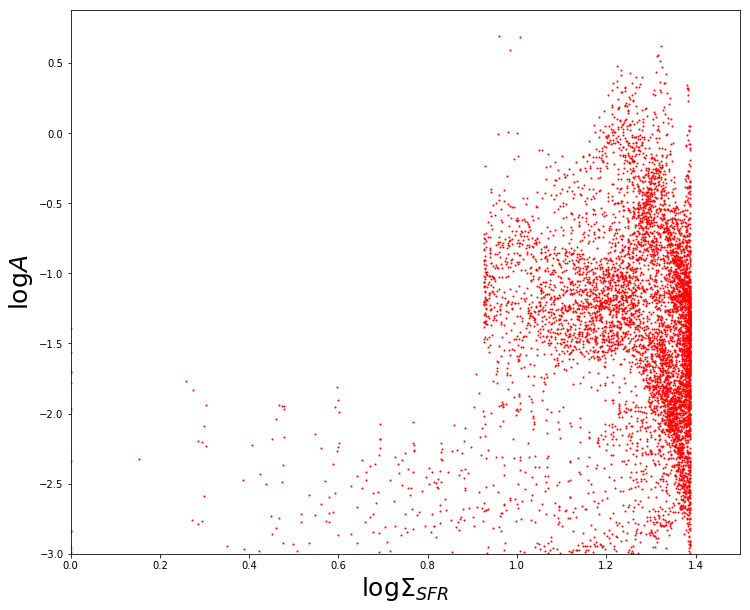

In [60]:
fig = plt.figure(figsize=[12,10])
indxs = (Sigma_SFR != nan) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(A_2d[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
#clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

#gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#mn=np.min(x)
#mx=np.max(x)
#x1=np.linspace(mn,mx,500)
#y1=gradient*x1+intercept
#plt.plot(x1,y1,'-r')
#print(gradient,intercept)

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{A}$',fontsize=25)
plt.xlim(0,1.5)
plt.ylim(-3,)

nan nan


/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(-3, 0.8754515766034305)

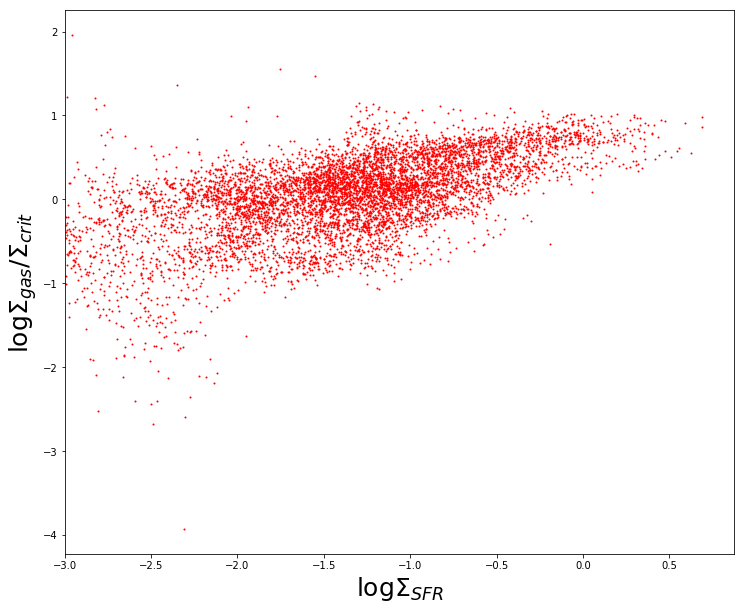

In [59]:
fig = plt.figure(figsize=[12,10])
shear_method = Sigma_gas/Sigma_crit
indxs = (Sigma_SFR != nan) & (shear_method > 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

x,y = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(shear_method[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
#clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{\Sigma_{gas}/\Sigma_{crit}}$',fontsize=25)
#plt.ylim(-2.5,3)
plt.xlim(-3,)

### Вычислим круговую скорость:

воспользуемся формулой 1 из [статьи](https://arxiv.org/pdf/astro-ph/0103507.pdf)

$$V^{mod1}(r,\phi) = V_s^{mod1} + V_{rot}^{mod1} cos\phi sin i$$

In [17]:
vel_los = np.load('./data/vel_los.npy')
phi = np.load('./data/phi.npy')

In [81]:
vel_circle = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        if (phi[i][j] == 90):
            vel_circle[i][j] = (vel_los[i][j]/1000.-717.2)/sini
        else:
            vel_circle[i][j] = (vel_los[i][j]/1000.-717.2)/sini/np.cos(phi[i][j] / 180. * np.pi)

Text(0.5, 1.0, 'circle velocity')

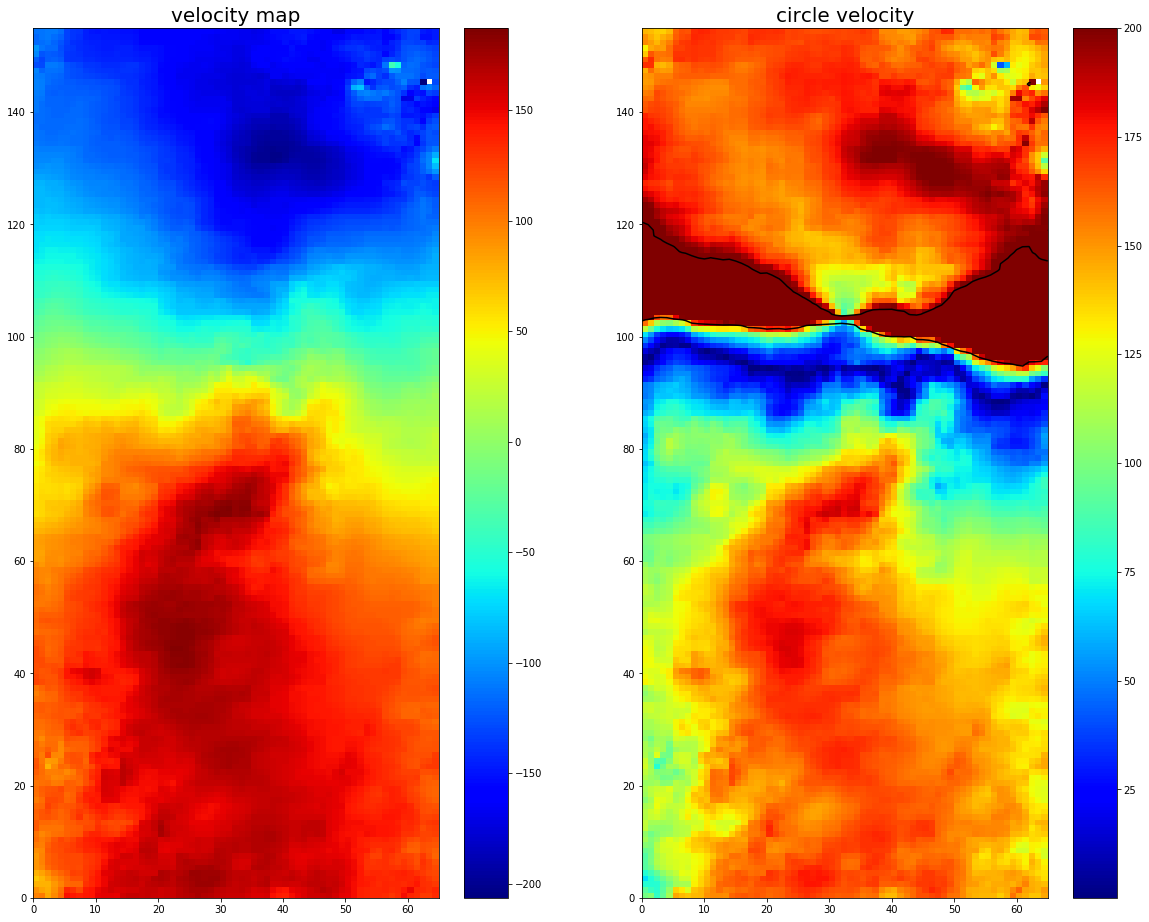

In [85]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[20, 16])
plt.subplot(1,2,1)

quadmesh = plt.pcolormesh(X, Y, (vel_los/1000.-717.2)/sini, cmap='jet')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'velocity map', fontsize=20)

plt.subplot(1,2,2)

CS = plt.contour(X, Y, np.abs(vel_circle), levels=[210,],aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, np.abs(vel_circle), cmap='jet')
quadmesh.cmap.set_under('white')
quadmesh.set_clim(vmax = 200)
plt.colorbar()
plt.title(r'circle velocity', fontsize=20)

### Получим residuals

In [89]:
residuals = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        residuals[i][j] = np.abs(vel_circle[i][j]) - velocity_approx(dist_kpc[i][j])

Text(0.5, 1.0, 'residuals')

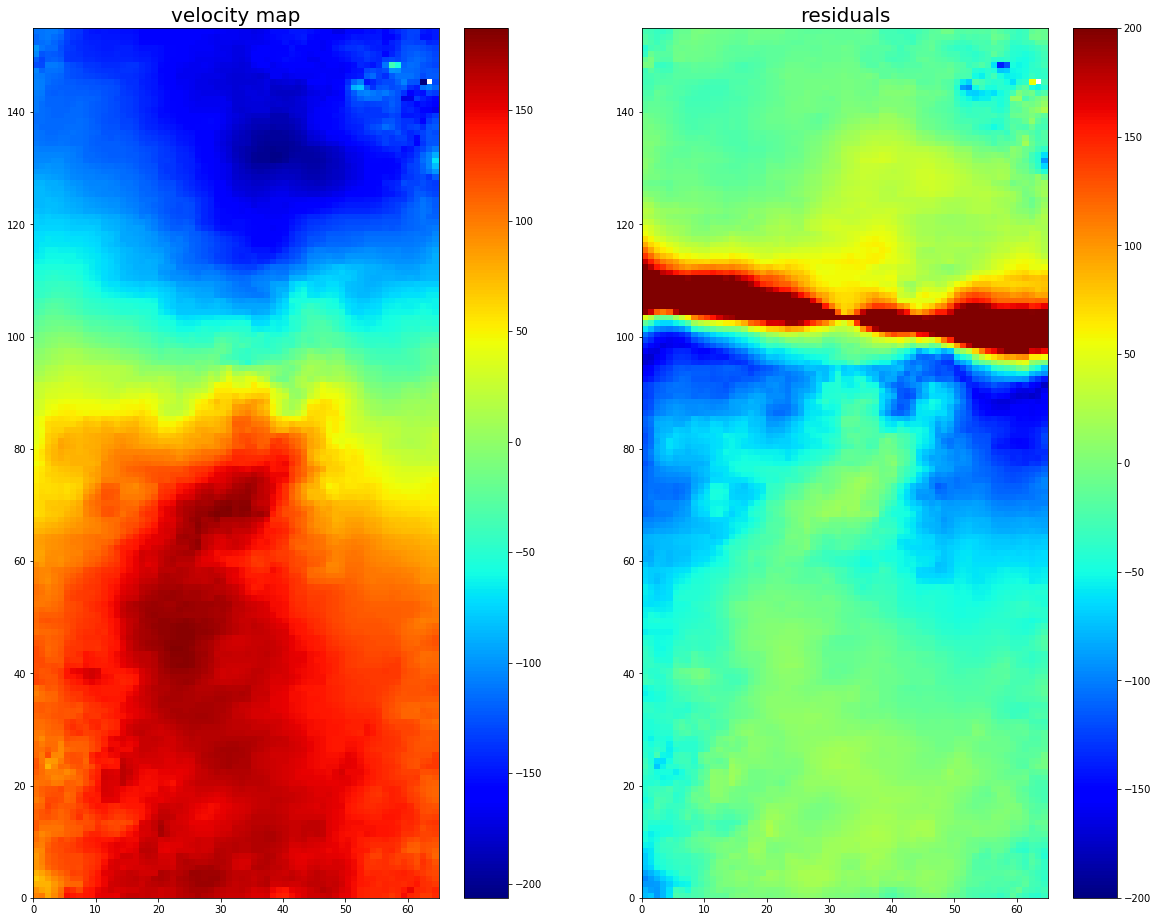

In [91]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[20, 16])
plt.subplot(1,2,1)

quadmesh = plt.pcolormesh(X, Y, (vel_los/1000.-717.2)/sini, cmap='jet')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'velocity map', fontsize=20)

plt.subplot(1,2,2)

#CS = plt.contour(X, Y, np.abs(vel_circle), levels=[210,],aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, residuals, cmap='jet')
quadmesh.cmap.set_under('white')
quadmesh.set_clim(vmin=-200.,vmax = 200)
plt.colorbar()
plt.title(r'residuals', fontsize=20)